In [195]:
!pip install yfinance
!pip install pmdarima

In [196]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import yfinance as yf


In [197]:
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker,start=start_date,end=end_date)
    return stock_data

In [198]:
ticker_symbol = 'AAPL'
start_date = "2010-01-01"
end_date = "2023-01-01"

In [199]:
stock_data = get_stock_data(ticker_symbol, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


In [200]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.478999,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.490199,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.386966,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.375157,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.417541,447610800


In [201]:
csv_filename = 'commbank_stock_data.csv'
stock_data.to_csv(csv_filename)

In [202]:
stock_data['Percentage'] = stock_data['Adj Close'].pct_change() * 100


stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,Percentage
Date,,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.478999,493729600,NaN
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.490199,601904800,0.172873
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.386966,552160000,-1.590604
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.375157,477131200,-0.184890
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.417541,447610800,0.664826


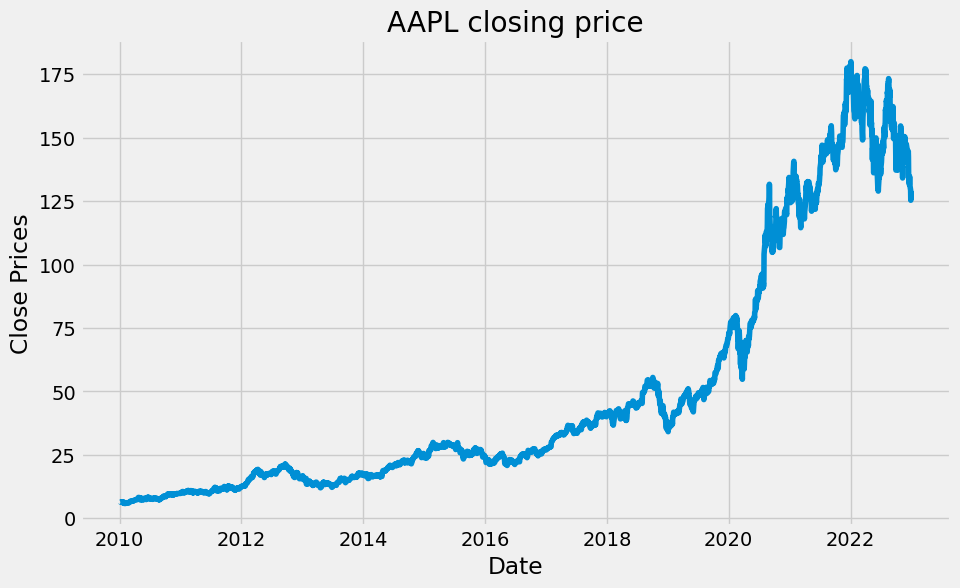

In [203]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Adj Close'])
plt.title(f'{ticker_symbol} closing price')
plt.show()

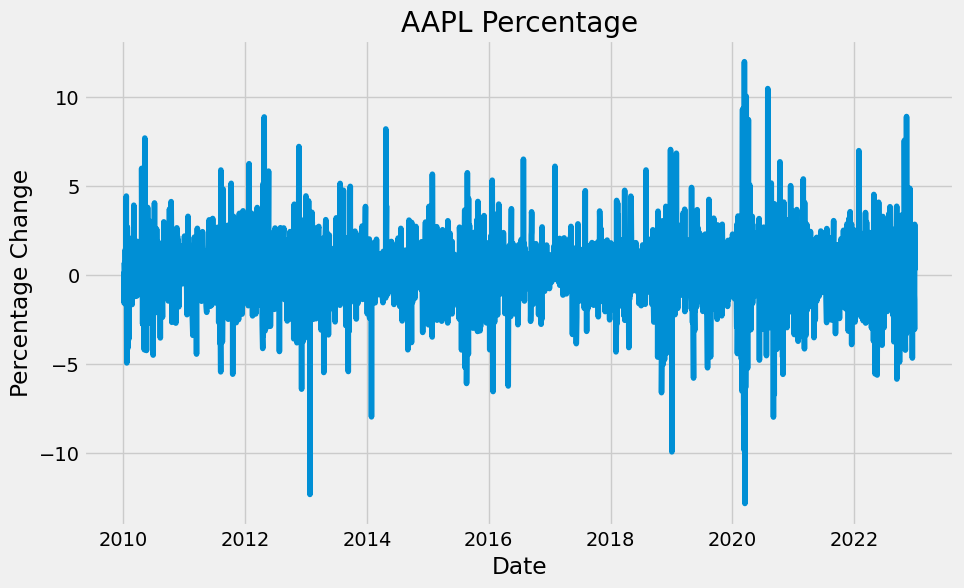

In [204]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.plot(stock_data['Percentage'])
plt.title(f'{ticker_symbol} Percentage')
plt.show()

<Axes: ylabel='Density'>

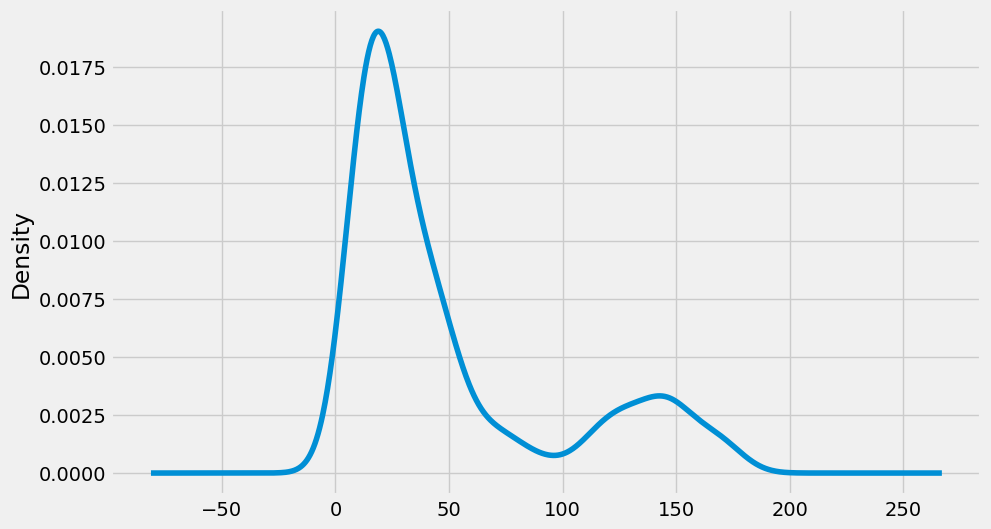

In [205]:
stock_data["Adj Close"].plot(kind='kde')

<Axes: ylabel='Density'>

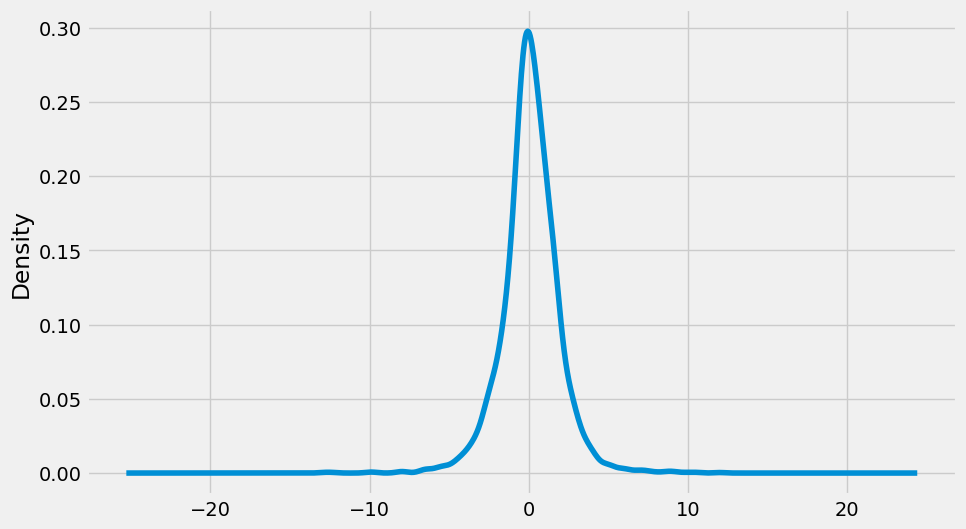

In [206]:
stock_data["Percentage"].plot(kind='kde')

In [207]:
df_close = stock_data["Close"]

In [208]:
df_percentage =stock_data["Percentage"].dropna()

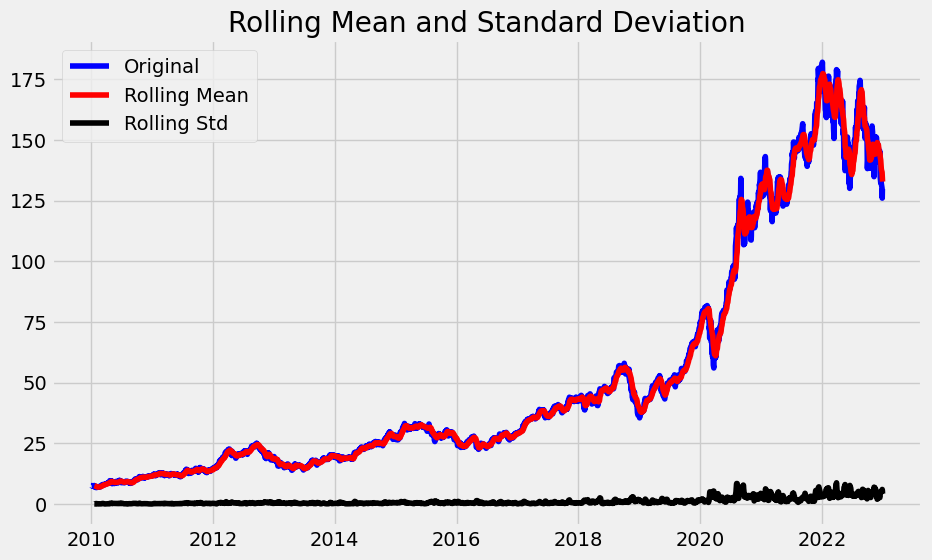

Results of dickey fuller test
Test Statistics                  -0.287761
p-value                           0.927220
No. of lags used                 22.000000
Number of observations used    3249.000000
critical value (1%)              -3.432364
critical value (5%)              -2.862430
critical value (10%)             -2.567244
dtype: float64


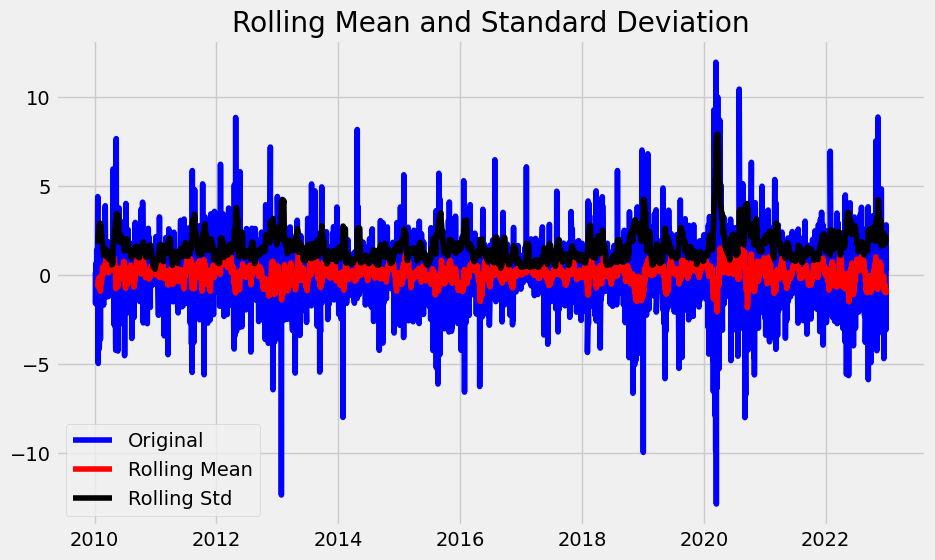

Results of dickey fuller test
Test Statistics               -1.170008e+01
p-value                        1.576392e-21
No. of lags used               2.100000e+01
Number of observations used    3.249000e+03
critical value (1%)           -3.432364e+00
critical value (5%)           -2.862430e+00
critical value (10%)          -2.567244e+00
dtype: float64


In [209]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)
test_stationarity(df_percentage)

<Figure size 1000x600 with 0 Axes>

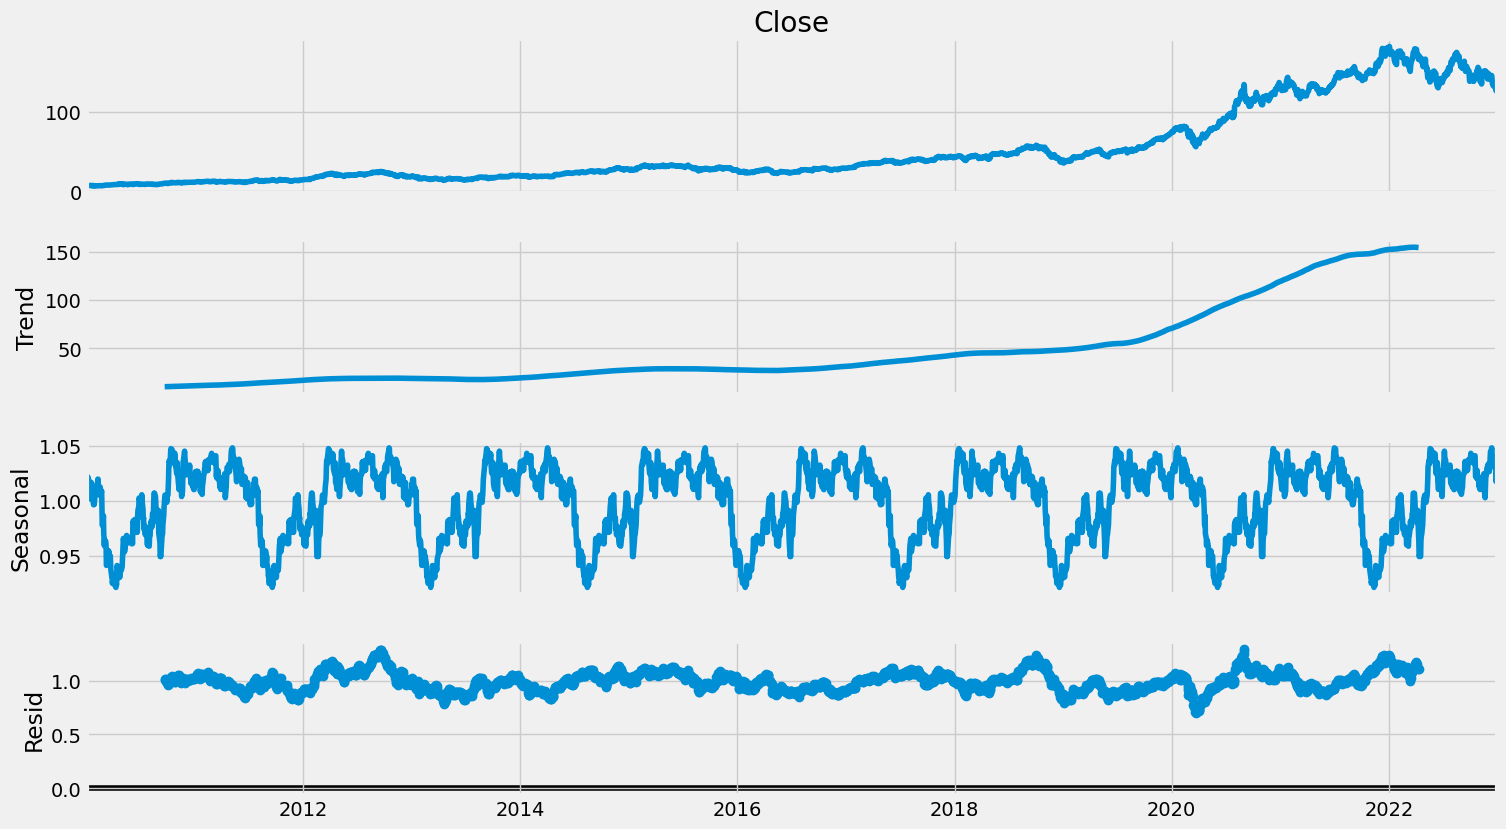

In [210]:
result = seasonal_decompose(df_close, model='multiplicative', period = 365)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

<Figure size 1000x600 with 0 Axes>

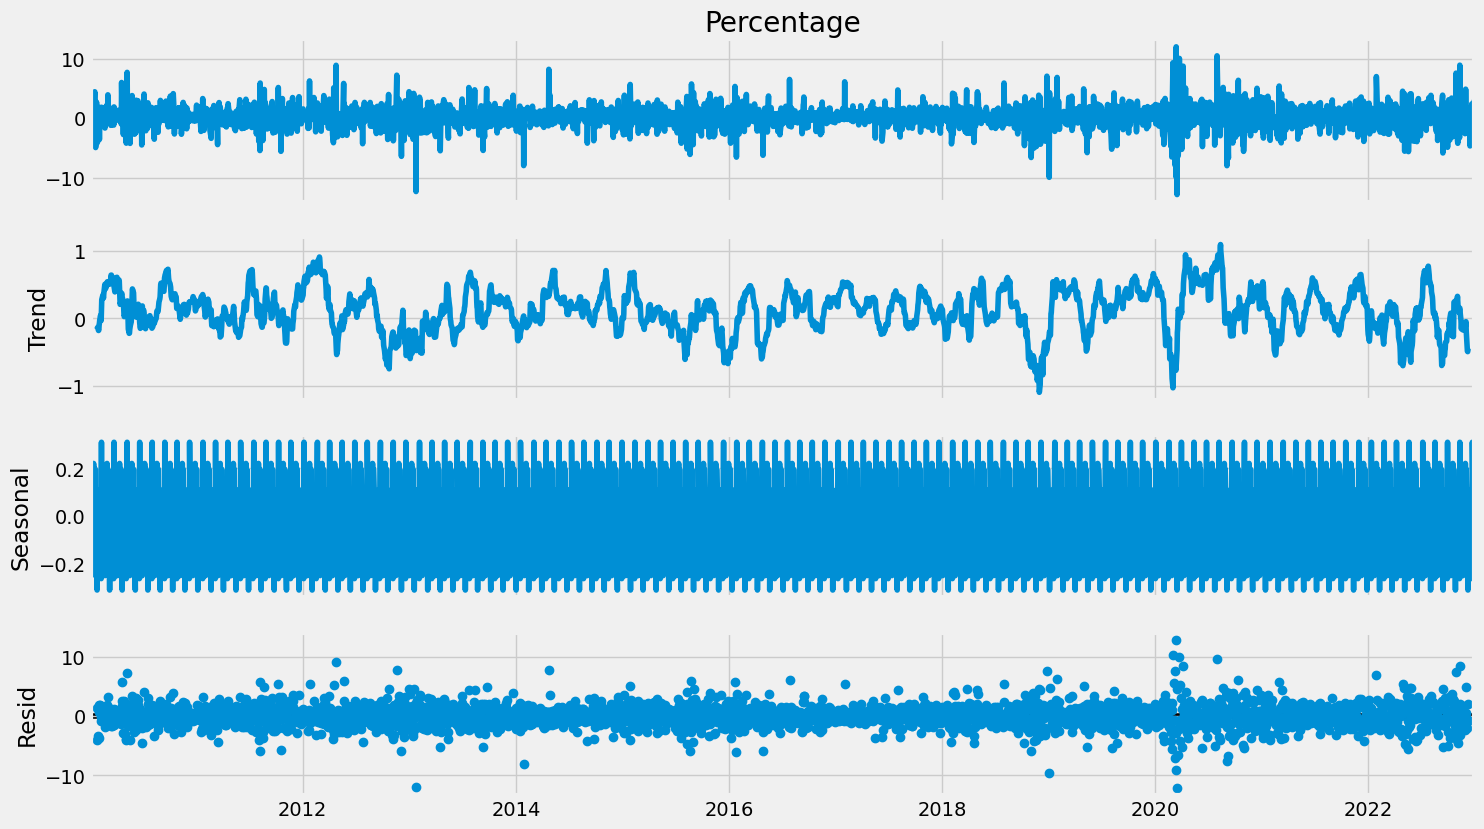

In [211]:
result = seasonal_decompose(df_percentage, model='additive', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

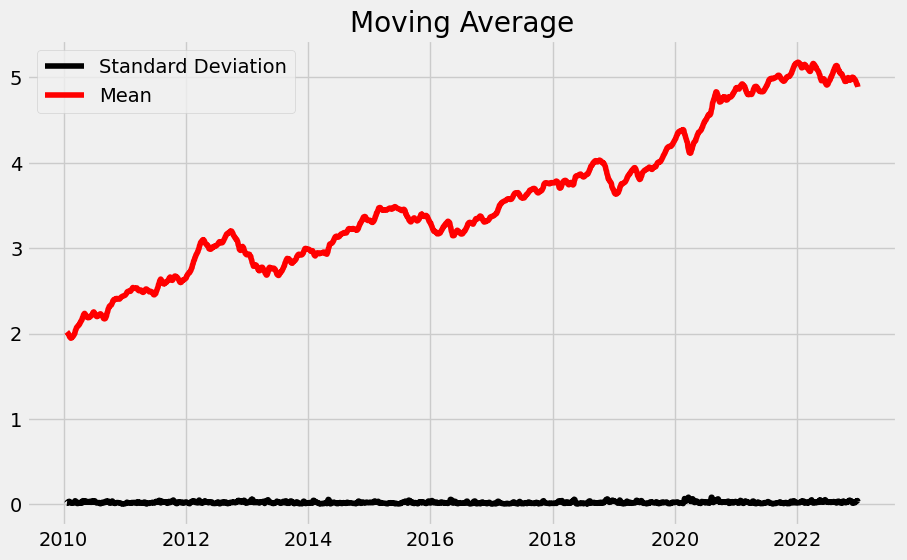

In [212]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()


1


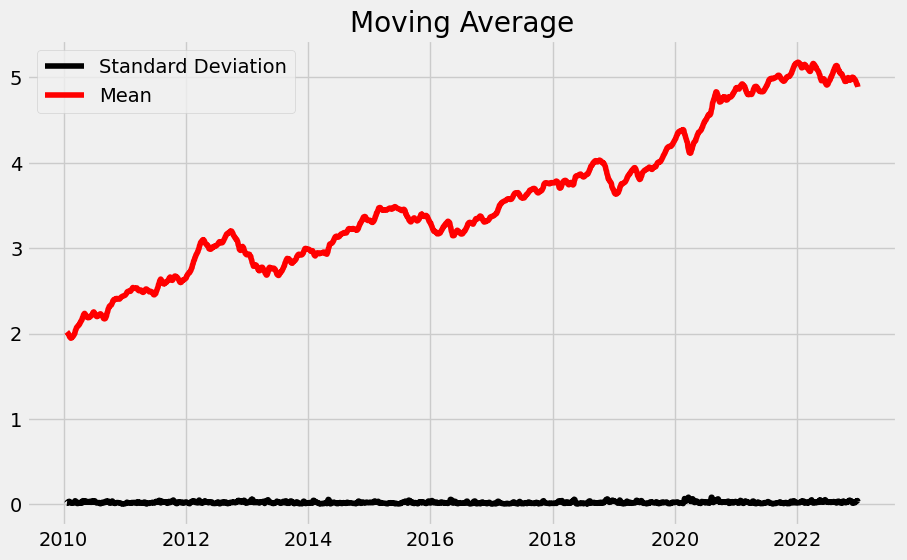

In [213]:
from pmdarima.arima.utils import ndiffs
print(ndiffs(df_log))
df_close_diff = df_log
moving_avg = df_close_diff.rolling(12).mean()
std_dev = df_close_diff.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

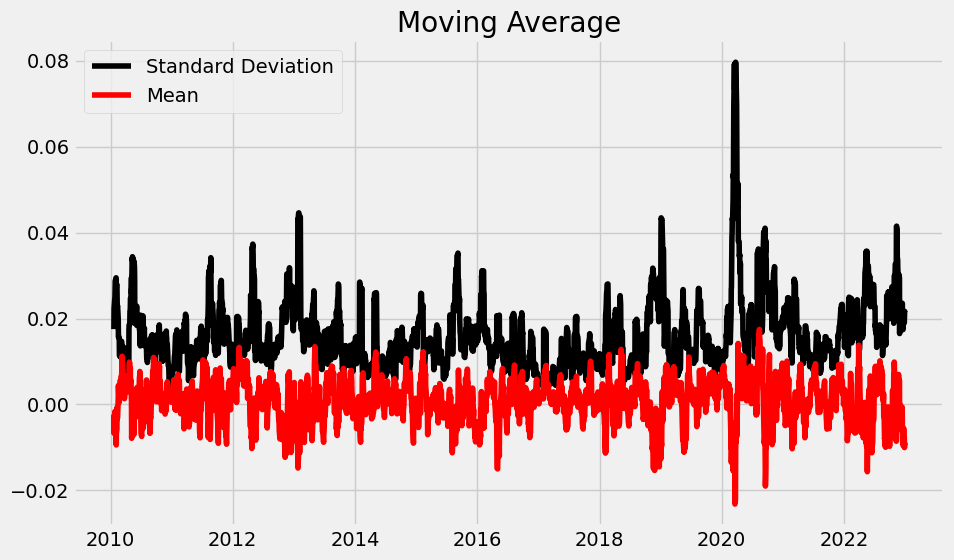

In [214]:

df_close_diff = df_log.diff()
moving_avg = df_close_diff.rolling(12).mean()
std_dev = df_close_diff.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

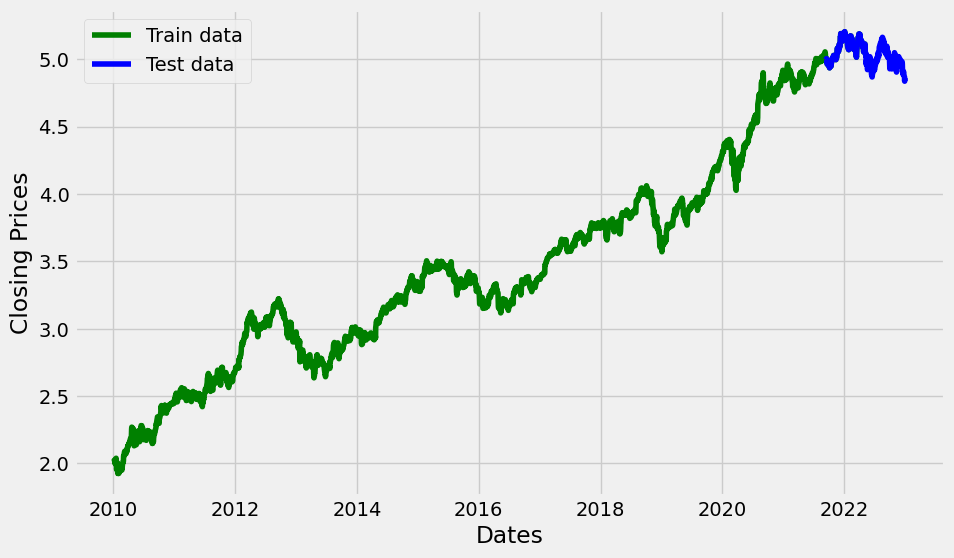

In [215]:
#split data into train and training set

train_data, test_data = df_log[3:int(len(df_log)*0.95)], df_log[int(len(df_log)*0.90):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

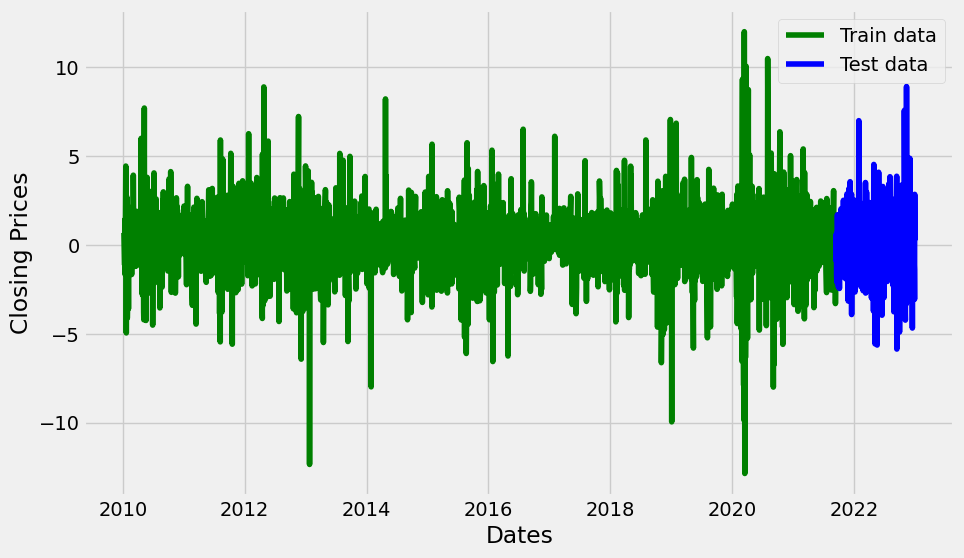

In [216]:
df_percentage = df_percentage.dropna()
train_data_per, test_data_per = df_percentage[3:int(len(df_percentage)*0.90)], df_percentage[int(len(df_percentage)*0.90):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data_per, 'green', label='Train data')
plt.plot(test_data_per, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16202.055, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16207.192, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16207.099, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16194.653, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-16205.333, Time=0.74 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16205.876, Time=0.60 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16203.305, Time=1.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-16198.879, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 3.908 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3105
Model:               SARIMAX(1, 1, 0)   Log Likelihood                8106.596
Date:                Fri, 24 Nov 2023   AIC                         -16207.192
Time:               

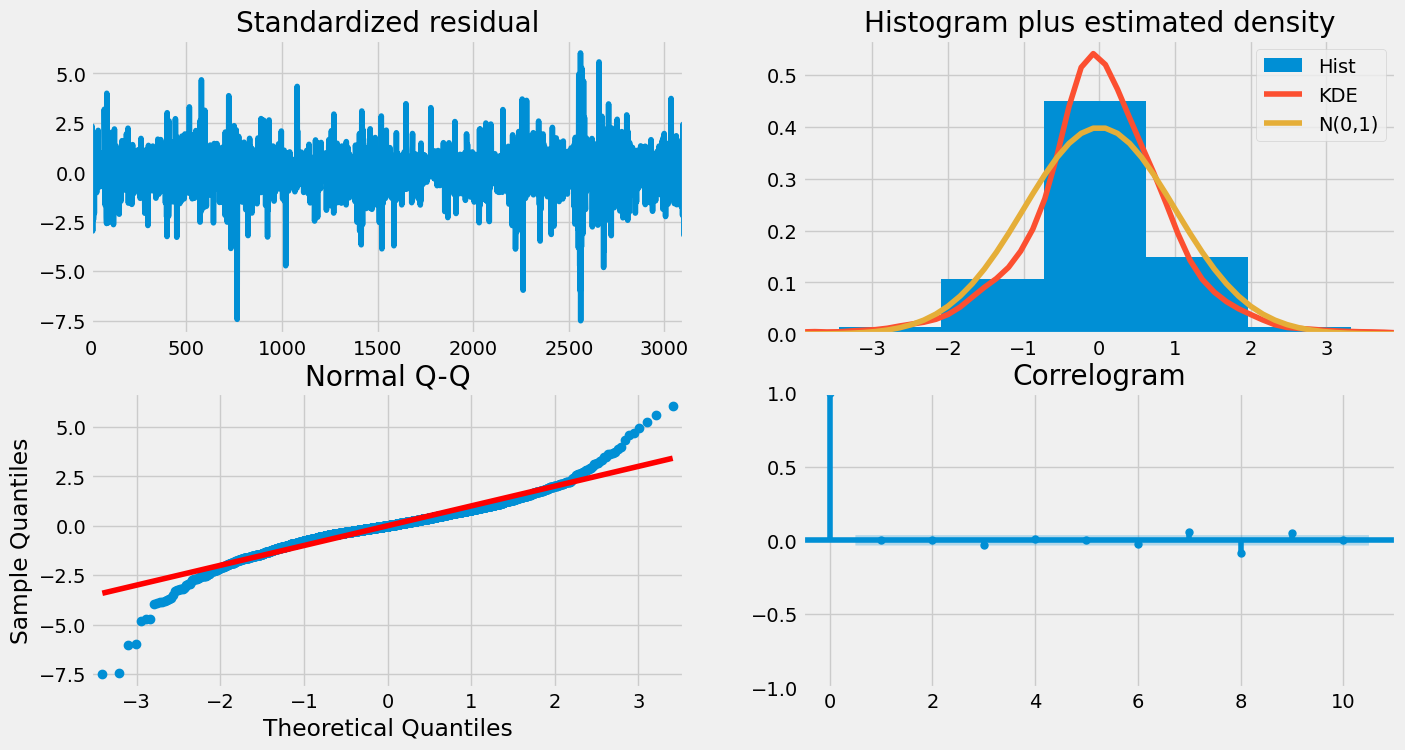

In [217]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()
print()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=11694.788, Time=1.67 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11730.264, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=11725.171, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=11725.388, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=11727.561, Time=1.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=11727.562, Time=0.43 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=11696.472, Time=4.64 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=11696.437, Time=4.24 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=11725.570, Time=0.29 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=11728.178, Time=1.42 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=11728.418, Time=1.89 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=11697.759, Time=6.26 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=11715.608, Time=5.15 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 27.394 seconds
        

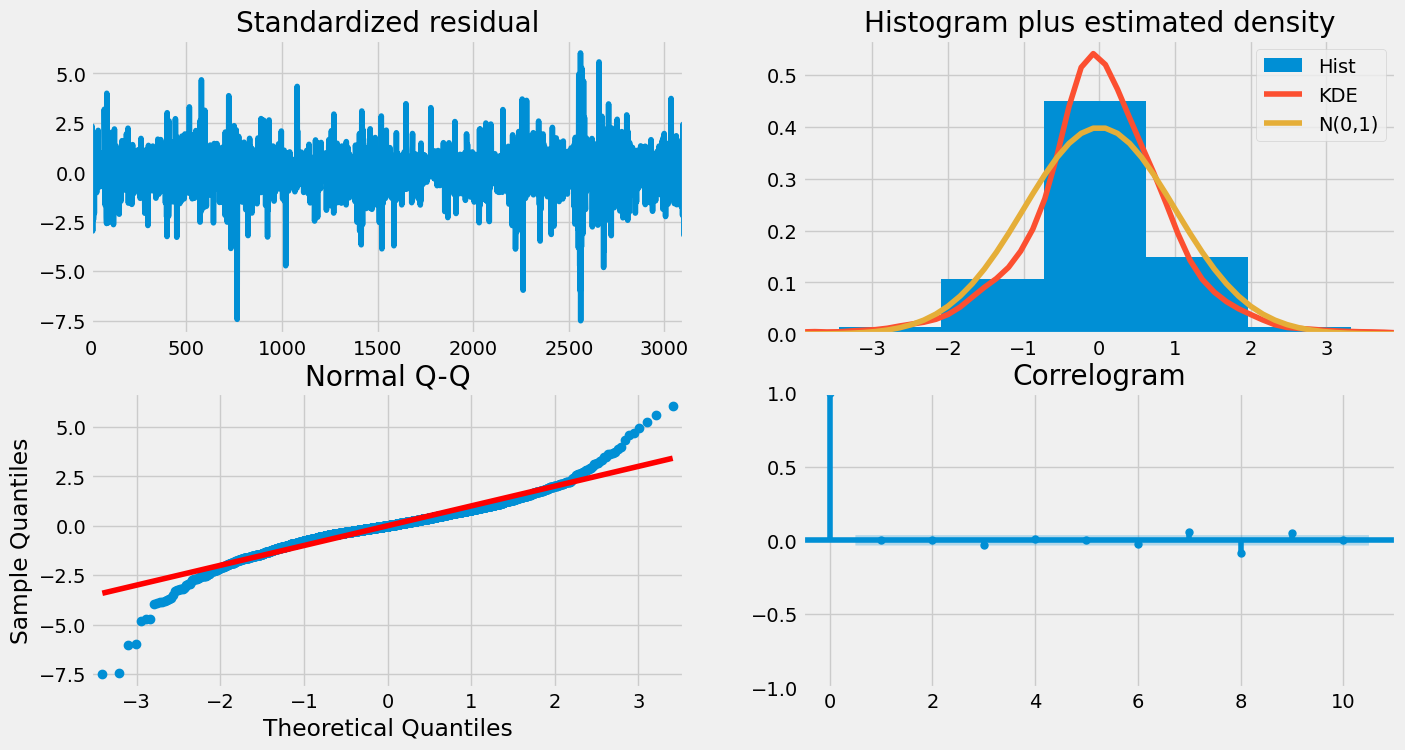

In [218]:

model_autoARIMA_per = auto_arima(train_data_per, start_p=2, start_q=2,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3,  # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=1, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [219]:
model = ARIMA(train_data, order=(3,0,1))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3105
Model:                 ARIMA(3, 0, 1)   Log Likelihood                8099.900
Date:                Fri, 24 Nov 2023   AIC                         -16187.800
Time:                        02:28:18   BIC                         -16151.556
Sample:                             0   HQIC                        -16174.786
                               - 3105                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4899      0.964      3.621      0.000       1.601       5.379
ar.L1          0.6454      0.986      0.654      0.513      -1.288       2.578
ar.L2          0.3507      0.937      0.374      0.7

In [220]:
model = ARIMA(train_data_per, order=(3,0,1))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:             Percentage   No. Observations:                 2940
Model:                 ARIMA(3, 0, 1)   Log Likelihood               -5851.248
Date:                Fri, 24 Nov 2023   AIC                          11714.496
Time:                        02:28:21   BIC                          11750.413
Sample:                             0   HQIC                         11727.428
                               - 2940                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1227      0.032      3.824      0.000       0.060       0.186
ar.L1         -0.1588      0.442     -0.359      0.720      -1.026       0.708
ar.L2          0.0033      0.026      0.124      0.9

In [221]:
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.api as smt
import statsmodels as sm
# define a function to plot ACF and PACF to determine p and q
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[0]
        ts_ax.set_title(f'Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

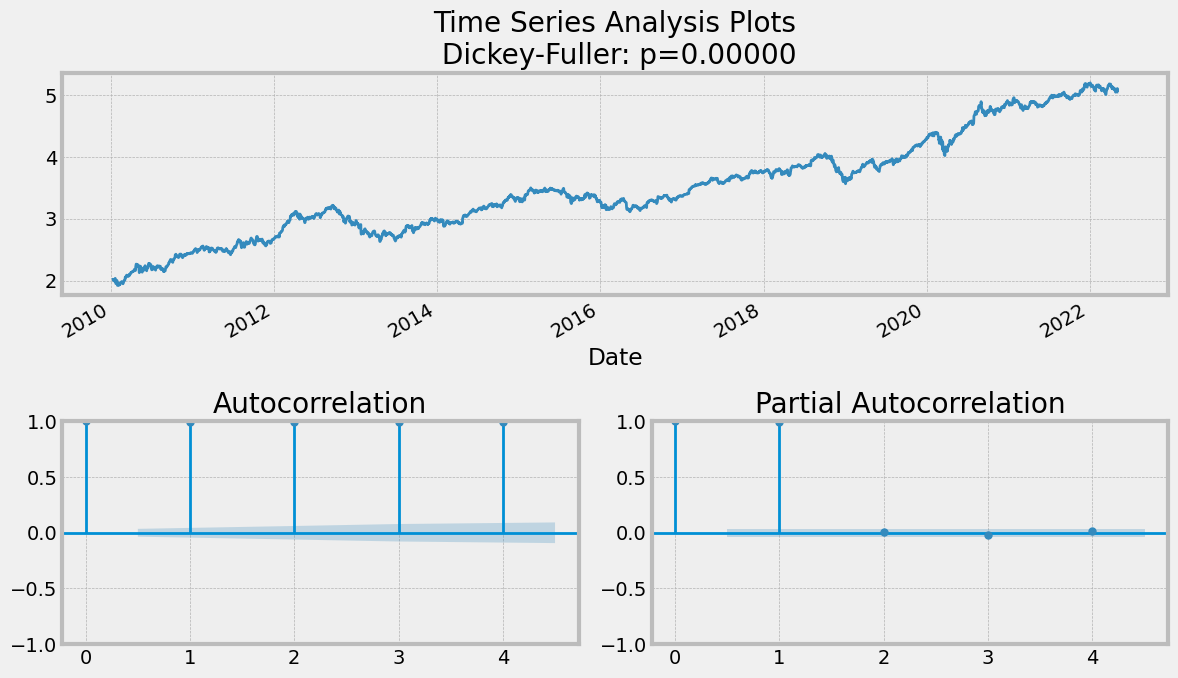

In [222]:
tsplot(train_data,lags=4)

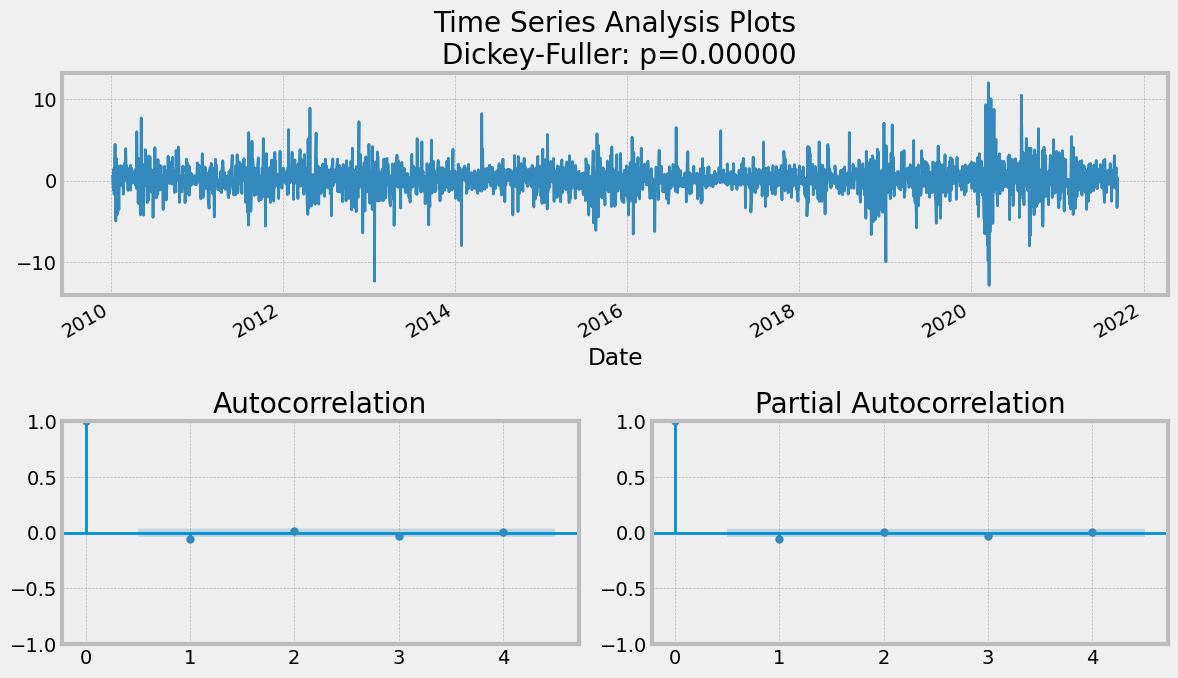

In [223]:
tsplot(train_data_per,lags=4)

In [224]:
model = ARIMA(train_data,order = (3,0,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3105
Model:                 ARIMA(3, 0, 1)   Log Likelihood                8099.900
Date:                Fri, 24 Nov 2023   AIC                         -16187.800
Time:                        02:28:24   BIC                         -16151.556
Sample:                             0   HQIC                        -16174.786
                               - 3105                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4899      0.964      3.621      0.000       1.601       5.379
ar.L1          0.6454      0.986      0.654      0.513      -1.288       2.578
ar.L2          0.3507      0.937      0.374      0.7

In [225]:
# in-sample rolling forecast
# split the training set removing the last 2 months 

size = len(test_data)

history = [x for x in train_data] ## list

predictions = []

for t in range(size):
    
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test_data[t]
    history.append(obs)
    

In [226]:
model = ARIMA(train_data,order=(0,1,1))
model_fit = model.fit()
residuals_test = train_data - model_fit.fittedvalues
residuals_test = residuals_test.reset_index()
test =  model_fit.fittedvalues.reset_index()
residuals_test["Forecast Values"] = test[0]
residuals_test = residuals_test.rename(columns={0:'residual'})


In [227]:
forecasted_values =  pd.DataFrame({
    
    'Date' : test_data.index,
    'Actual Values' : test_data.values,
    'Forecast Values' : predictions
    
})
forecasted_values.head(10)

,Date,Actual Values,Forecast Values
0,2021-09-14,4.998023,5.057882
1,2021-09-15,5.004148,5.000721
2,2021-09-16,5.002536,5.003871
3,2021-09-17,4.984017,5.002609
4,2021-09-20,4.962425,4.984854
5,2021-09-21,4.965847,4.963391
6,2021-09-22,4.982579,4.965694
7,2021-09-23,4.989275,4.981830
8,2021-09-24,4.989888,4.988977
9,2021-09-27,4.979282,4.989861


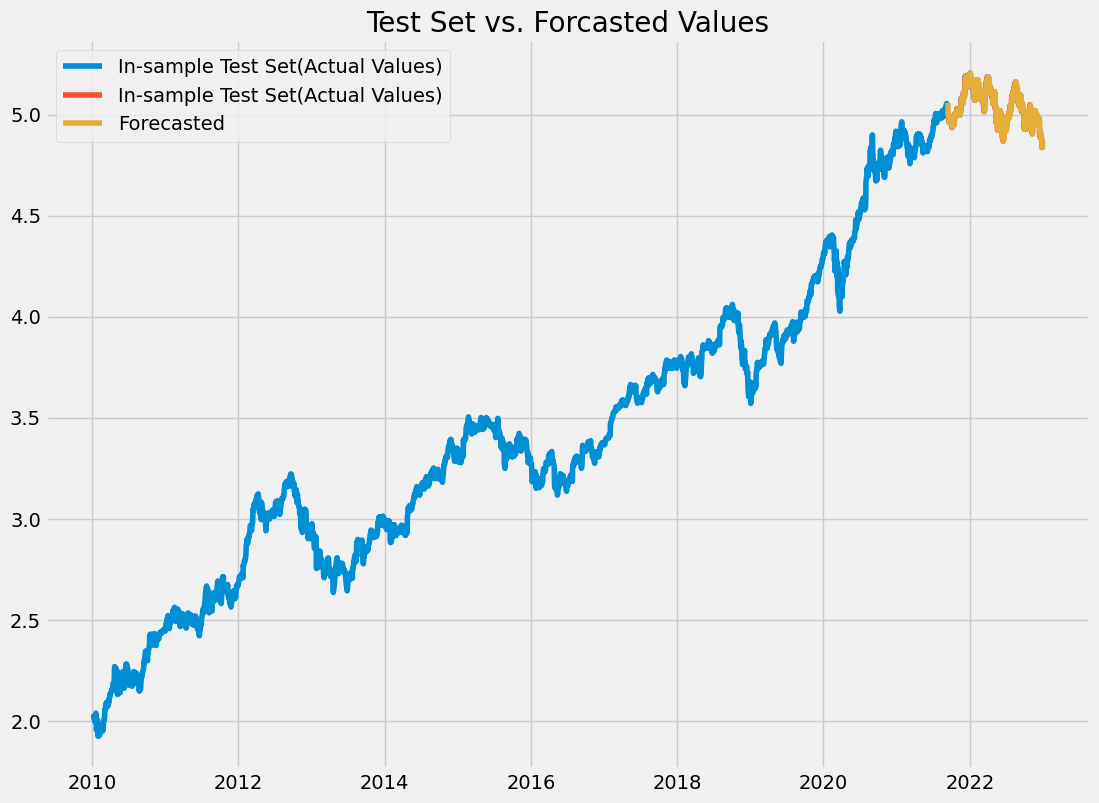

In [228]:
fig, ax = plt.subplots(figsize = (12,9))

plt.plot(train_data.index, train_data.values, label = 'In-sample Test Set(Actual Values)')
plt.plot(test_data.index, test_data.values, label = 'In-sample Test Set(Actual Values)')
plt.plot(forecasted_values.Date, forecasted_values['Forecast Values'], label='Forecasted')
plt.title('Test Set vs. Forcasted Values')

plt.legend()
plt.grid(True)
plt.show()

In [239]:
forecasted_values["residual"] = forecasted_values["Actual Values"] - forecasted_values["Forecast Values"]
forecasted_values.head()


(328, 4)

In [230]:
mse = np.mean(((forecasted_values["residual"]))**2)
mae = np.mean(np.abs(forecasted_values["residual"]))
print(mse,mae)

0.0004484811172702314 0.016157796965991497


In [231]:
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential

def train_lstm(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(x_train.shape[1], 1), return_sequences=True))
    model.add(Dropout(0.2))  # Dropout after the first LSTM layer
    model.add(LSTM(50, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))  # Dropout after the second LSTM layer
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae', metrics=["mae"])

    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=validation_split)

    return model

In [232]:
from keras.models import Sequential
from keras.layers import LSTM, Dense


x_train = residuals_test["Forecast Values"].values.reshape(-1, 1, 1)
y_train = residuals_test["residual"].values
model_lstm = train_lstm(x_train,y_train,100)


Epoch 1/100
88/88 [==============================] - 4s 10ms/step - loss: 0.0135 - mae: 0.0135 - val_loss: 0.0134 - val_mae: 0.0134
Epoch 2/100
88/88 [==============================] - 0s 4ms/step - loss: 0.0133 - mae: 0.0133 - val_loss: 0.0128 - val_mae: 0.0128
Epoch 3/100
88/88 [==============================] - 0s 5ms/step - loss: 0.0132 - mae: 0.0132 - val_loss: 0.0129 - val_mae: 0.0129
Epoch 4/100
88/88 [==============================] - 0s 5ms/step - loss: 0.0132 - mae: 0.0132 - val_loss: 0.0128 - val_mae: 0.0128
Epoch 5/100
88/88 [==============================] - 0s 5ms/step - loss: 0.0132 - mae: 0.0132 - val_loss: 0.0132 - val_mae: 0.0132
Epoch 6/100
88/88 [==============================] - 0s 5ms/step - loss: 0.0133 - mae: 0.0133 - val_loss: 0.0130 - val_mae: 0.0130
Epoch 7/100
88/88 [==============================] - 0s 5ms/step - loss: 0.0132 - mae: 0.0132 - val_loss: 0.0129 - val_mae: 0.0129
Epoch 8/100
88/88 [==============================] - 0s 5ms/step - loss: 0.0132 - 

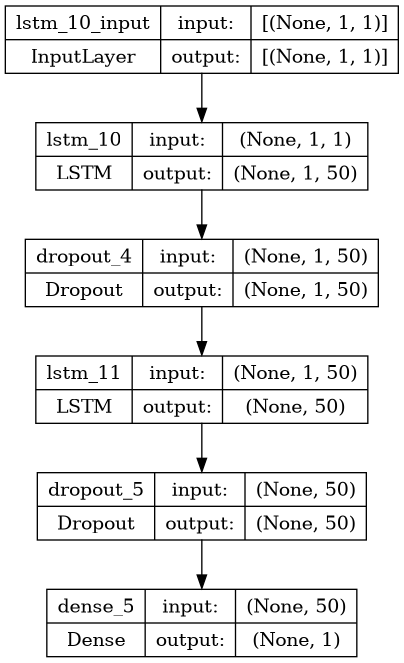

In [233]:
from keras.utils import plot_model

plot_model(model_lstm, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)


In [234]:
x_test = forecasted_values["Forecast Values"].values.reshape(-1, 1, 1)
y_test = forecasted_values["residual"].values
y_actual = forecasted_values["Actual Values"].values
# Make predictions
y_pred = model_lstm.predict(x_test)
# Evaluate performance
mse1 = np.mean((y_actual - (x_test))**2)
mae1 = np.mean(np.abs(y_actual - (x_test)))

mse = np.mean((y_actual - (x_test + y_pred.squeeze()))**2)
mae = np.mean(np.abs(y_actual - (x_test + y_pred.squeeze())))

print(mse,mae,mse1,mae1)

11/11 [==============================] - 0s 2ms/step
0.013781621485899441 0.09524262019920318 0.013781725456483008 0.09524291606008288


In [235]:
size = len(test_data)

history = [x for x in train_data] ## list
predictions = []


    
model = ARIMA(history, order=(0,1,1))
model_fit = model.fit()
    
output = model_fit.forecast(size)


    

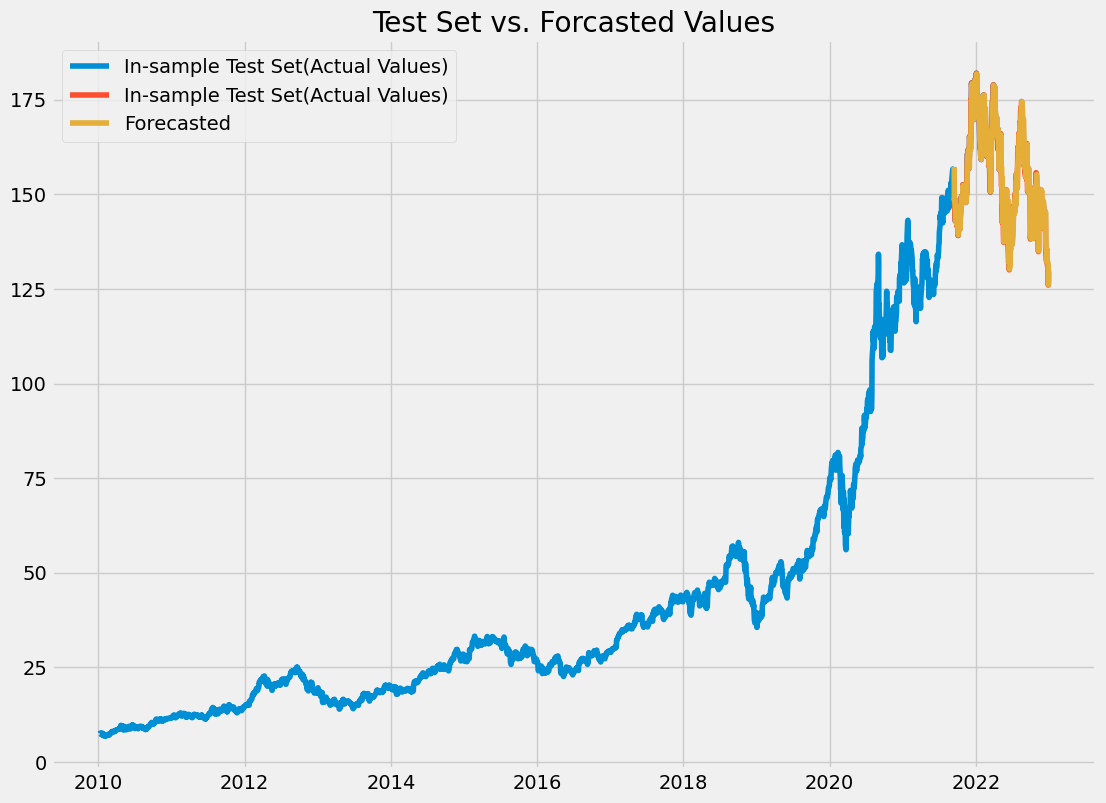

In [237]:
fig, ax = plt.subplots(figsize = (12,9))
plt.plot(train_data.index, np.exp(train_data.values), label = 'In-sample Test Set(Actual Values)')

plt.plot(test_data.index, np.exp(test_data.values), label = 'In-sample Test Set(Actual Values)')
plt.plot(forecasted_values.Date, np.exp(forecasted_values['Forecast Values']), label='Forecasted')
plt.title('Test Set vs. Forcasted Values')

plt.legend()
plt.grid(True)
plt.show()